In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 
from torchsummary import summary

In [14]:
batch_size = 32
lr = 0.001
epochs = 20

device = 'cuda'
data_dir = 'Person-Re-Id-Dataset/train/'
csv = 'Person-Re-Id-Dataset/train.csv'

In [15]:
df = pd.read_csv(csv)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [29]:
row = df.iloc[14]
A_img = io.imread(data_dir + row.Anchor)
P_img = io.imread(data_dir + row.Positive)
N_img = io.imread(data_dir + row.Negative)
# P_img

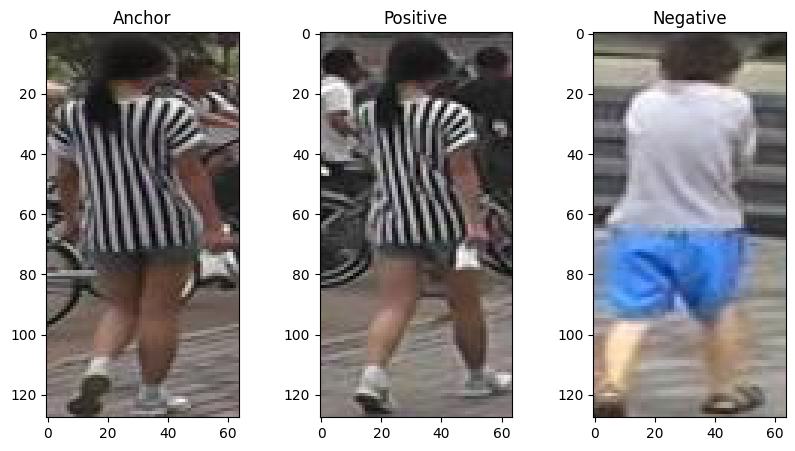

In [30]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [31]:
train_df, valid_df = train_test_split(df,test_size = 0.20,random_state = 42)

In [33]:
class dataset(Dataset):
    def __init__(self,df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        A_img = torch.from_numpy(io.imread(data_dir + row.Anchor)).permute(2,0,1)/255.0
        P_img = torch.from_numpy(io.imread(data_dir + row.Positive)).permute(2,0,1)/255.0
        N_img = torch.from_numpy(io.imread(data_dir + row.Negative)).permute(2,0,1)/255.0
        return A_img,P_img,N_img
        

In [35]:
trainset = dataset(train_df)
validset = dataset(valid_df)

print(len(trainset),len(validset))

3200 800


In [38]:
trainloader = DataLoader(trainset,batch_size = batch_size,shuffle = True)
validloader = DataLoader(validset,batch_size = batch_size)

len(trainloader),len(validloader)

(100, 25)

In [41]:
for A,P,N in trainloader:
    break
A.shape

torch.Size([32, 3, 128, 64])

In [46]:
class SiameseN(nn.Module):
    def __init__ (self,emb_size = 512):
        super(SiameseN,self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0',pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features , out_features = emb_size)
    def forward(self,images):
        embeddings = self.efficientnet(images)
        return embeddings
        

In [47]:
model = SiameseN()
model.to(device)

C:\Users\91987\anaconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91987\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


SiameseN(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=

In [50]:
summary(model,(3, 128, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             864
          Identity-2           [-1, 32, 64, 32]               0
              SiLU-3           [-1, 32, 64, 32]               0
    BatchNormAct2d-4           [-1, 32, 64, 32]              64
            Conv2d-5           [-1, 32, 64, 32]             288
          Identity-6           [-1, 32, 64, 32]               0
              SiLU-7           [-1, 32, 64, 32]               0
    BatchNormAct2d-8           [-1, 32, 64, 32]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13           [-1, 32, 64, 32]               0
           Conv2d-14           [-1, 16,

In [60]:
def train_fn(model,dataloader,optimizer,criterion):
    model.train() # ON Dropout
    total_loss = 0.0
    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(device),P.to(device),N.to(device)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        loss = criterion(A_embs,P_embs,N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss +=loss.item()
    return total_loss/len(dataloader)

In [64]:
def eval_fn(model,dataloader,criterion):
    model.eval() # ON Dropout
    total_loss = 0.0
    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(device),P.to(device),N.to(device)
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            loss = criterion(A_embs,P_embs,N_embs)
    
            total_loss +=loss.item()
        return total_loss/len(dataloader)

In [67]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr,weight_decay= 0.001)

In [68]:
best_valid_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(model,trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader,criterion)

    if valid_loss< best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        best_valid_loss = valid_loss
        print('Saved Weights')

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.78it/s]


Saved Weights
EPOCHS: 1 train_loss: 0.12739941731095314 valid_loss: 0.21334146112203597


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.02it/s]


EPOCHS: 2 train_loss: 0.07825839065015316 valid_loss: 0.2344857320189476


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.90it/s]


Saved Weights
EPOCHS: 3 train_loss: 0.08637345530092716 valid_loss: 0.14296139791607856


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.24it/s]


Saved Weights
EPOCHS: 4 train_loss: 0.05250208210200071 valid_loss: 0.11274906069040298


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.46it/s]


EPOCHS: 5 train_loss: 0.056069930531084534 valid_loss: 0.1582155455648899


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.45it/s]


EPOCHS: 6 train_loss: 0.08346807815134526 valid_loss: 0.2430499005317688


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.46it/s]


EPOCHS: 7 train_loss: 0.0943754230812192 valid_loss: 0.1595286163687706


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.40it/s]


EPOCHS: 8 train_loss: 0.04855604339390993 valid_loss: 0.16241237595677377


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.61it/s]


EPOCHS: 9 train_loss: 0.059364946857094765 valid_loss: 0.1870543110370636


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.04it/s]


EPOCHS: 10 train_loss: 0.0988733695819974 valid_loss: 0.15243531316518782


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.38it/s]


EPOCHS: 11 train_loss: 0.06593131247907877 valid_loss: 0.172859488427639


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.21it/s]


EPOCHS: 12 train_loss: 0.0871337628737092 valid_loss: 0.12447362601757049


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.68it/s]


EPOCHS: 13 train_loss: 0.06195675894618034 valid_loss: 0.13886524006724357


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.54it/s]


Saved Weights
EPOCHS: 14 train_loss: 0.04857924003154039 valid_loss: 0.10512869328260421


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.44it/s]


EPOCHS: 15 train_loss: 0.0730561225488782 valid_loss: 0.15735379576683045


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.69it/s]


EPOCHS: 16 train_loss: 0.05646481487900019 valid_loss: 0.13432818710803984


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.94it/s]


Saved Weights
EPOCHS: 17 train_loss: 0.05098419876769185 valid_loss: 0.09882529303431511


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.15it/s]


EPOCHS: 18 train_loss: 0.07995540842413902 valid_loss: 0.19479599133133887


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.69it/s]


EPOCHS: 19 train_loss: 0.05198804829269647 valid_loss: 0.15797605499625206


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.58it/s]

EPOCHS: 20 train_loss: 0.07081354465335607 valid_loss: 0.17117911130189895


In [87]:
def get_encoding(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(data_dir+i)
            A = torch.from_numpy(A).permute(2,0,1)/255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names,encodings],axis = 1)
    return df_enc

In [88]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding(model,df['Anchor'])


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:38<00:00, 103.63it/s]


In [89]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.938790,-0.001672,-0.056013,0.512410,-0.323783,0.025901,0.079742,-0.008303,-0.008004,...,-0.001611,-0.619289,-0.210519,0.384953,-0.280070,-0.072930,0.044272,-0.007399,0.186331,0.056086
1,1420_c3s3_061978_03.jpg,1.317498,-0.000094,-0.026159,0.831610,-0.195765,0.020188,0.069476,-0.004802,-0.004819,...,-0.064485,-0.764233,-0.131229,0.378121,-0.166341,-0.064847,0.039525,-0.052726,0.115366,0.037916
2,1420_c5s3_062565_05.jpg,0.965367,-0.002301,-0.027458,0.320887,-0.187959,0.044936,0.069783,-0.011114,-0.003801,...,-0.152751,-0.834231,-0.162197,0.426821,-0.144338,-0.058047,0.031150,-0.010640,0.116798,0.024247
3,1420_c6s3_085592_04.jpg,1.183883,-0.001378,-0.097906,1.009373,-0.562998,0.039618,0.120034,-0.005459,-0.016300,...,0.151027,-0.464082,-0.298041,0.458440,-0.514494,-0.121179,0.078639,0.012608,0.308328,0.116372
4,0663_c5s3_085987_03.jpg,-0.421116,-0.010413,-0.220374,0.337538,-1.055965,0.042070,0.145641,-0.026211,-0.028155,...,0.434059,0.866576,-0.610756,0.015039,-0.950078,-0.132674,0.078087,0.246785,0.592346,0.173204


In [90]:
def euclidean_dist(img_enc, anc_enc_arr):
    distance = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return distance
    

In [107]:
idx = 90
img_name = df_enc['Anchor'].iloc[idx]
img_path = data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()
    print(img_enc.shape)
    

(1, 512)


In [108]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [109]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
    distance = np.append(distance,dist)

In [110]:
closest_idx = np.argsort(distance)


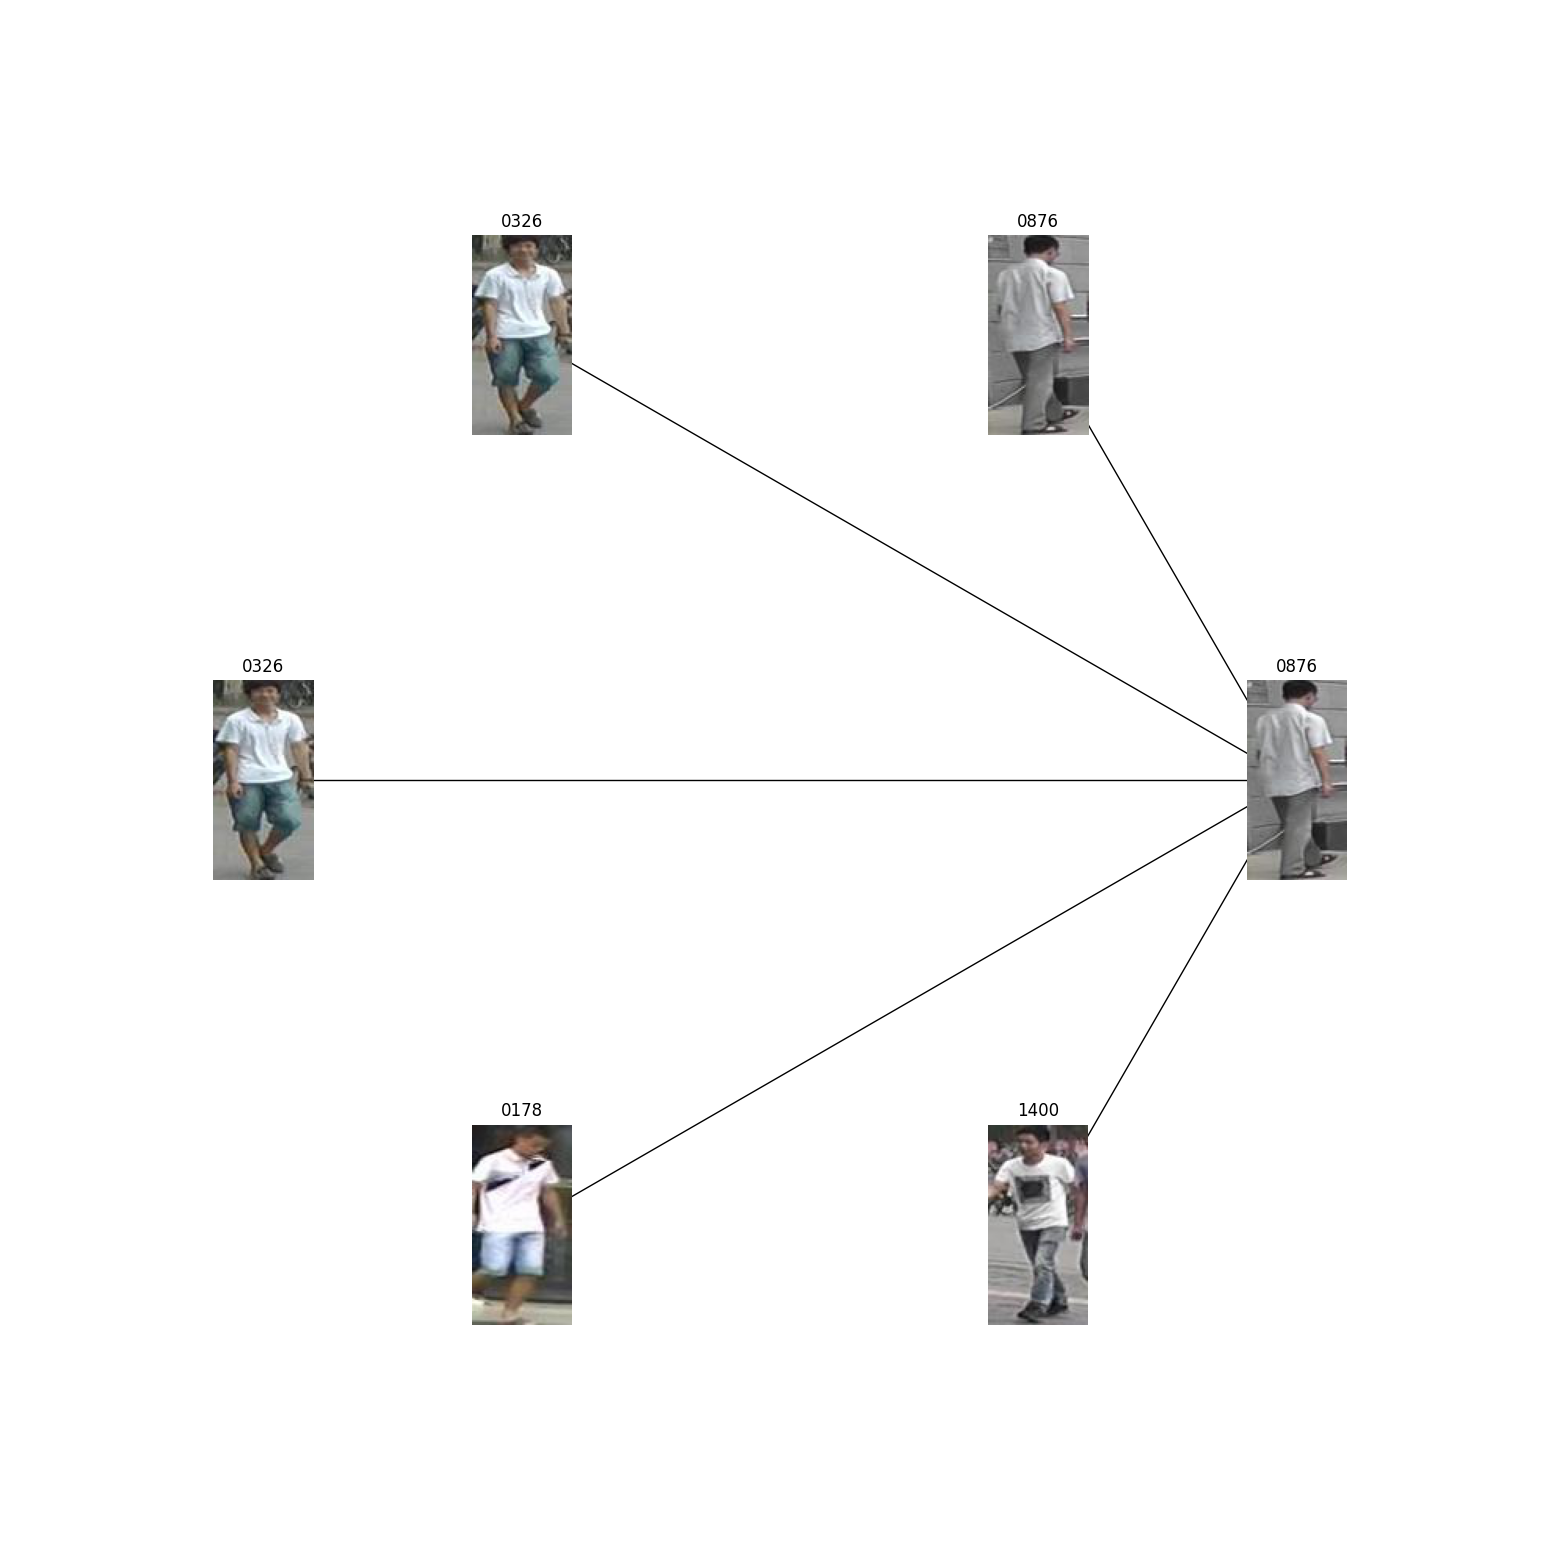

In [111]:
from utils import plot_closest_imgs
plot_closest_imgs(anc_img_names,data_dir,img,img_path,closest_idx,distance, no_of_closest = 5)